## 神经网络实现翻译

- 参考链接 : https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

- 论文参考链接 : https://arxiv.org/abs/1409.3215

In this project we will be teaching a neural network to translate from French to English.

最终实现的目标如下

```python
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

### 主要思想

An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 数据预处理&读取数据

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    """word → index (word2index) and index → word (index2word) dictionaries
       A count of each word word2count to use to later replace rare words.
    """
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
"""
 we will turn Unicode characters to ASCII, make everything lowercase, 
 and trim most punctuation.
"""

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [14]:
# 转换为ASCII, 大写变小写, 留下重要的标点, 去掉大部分的标点
normalizeString('I am a Boy!~$%^&')

'i am a boy ! '

In [5]:
def readLangs(lang1, lang2, reverse=False):
    """逐行读取file, 并将每行分为pair, 并做标准化
    """
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

为了加快训练的速度, 我们把句子长度最大设置为10, 同时我们过滤句子后使得其开头变为如i am, he is等词汇

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [20]:
# 会去掉单词个数超过10个的句子
# 会去掉不是以特定开头的句子
filterPairs([['i am a girl','i am a boy'],
             ['how are you','how are you'],
            ['i am a girl i am a girl i am a girl','i am a girl i am a girl']])

[['i am a girl', 'i am a boy']]

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [21]:
def prepareData(lang1, lang2, reverse=False):
    """开始读取语言的文件
    """
    # 读取文件, 返回的是句子对
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    # 过滤掉句子对中较长的句子, 和
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [22]:
# 开始读取数据
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


In [23]:
print(random.choice(pairs))

['il a accepte de faire le travail .', 'he s agreed to do the job .']


In [25]:
# 不同单词出现的次数
output_lang.word2index

{'i': 2,
 'm': 3,
 '.': 4,
 'ok': 5,
 'fat': 6,
 'fit': 7,
 'hit': 8,
 '!': 9,
 'ill': 10,
 'sad': 11,
 'shy': 12,
 'wet': 13,
 'he': 14,
 's': 15,
 'am': 16,
 'back': 17,
 'bald': 18,
 'busy': 19,
 'calm': 20,
 'cold': 21,
 'done': 22,
 'fine': 23,
 'free': 24,
 'full': 25,
 'glad': 26,
 'home': 27,
 'late': 28,
 'lazy': 29,
 'okay': 30,
 'safe': 31,
 'sick': 32,
 'sure': 33,
 'tall': 34,
 'thin': 35,
 'tidy': 36,
 'ugly': 37,
 'weak': 38,
 'well': 39,
 'is': 40,
 'old': 41,
 'a': 42,
 'dj': 43,
 'good': 44,
 'rich': 45,
 'here': 46,
 'cop': 47,
 'man': 48,
 'alone': 49,
 'armed': 50,
 'awake': 51,
 'blind': 52,
 'broke': 53,
 'crazy': 54,
 'cured': 55,
 'drunk': 56,
 'dying': 57,
 'early': 58,
 'first': 59,
 'fussy': 60,
 'going': 61,
 'loyal': 62,
 'lucky': 63,
 'lying': 64,
 'quiet': 65,
 'ready': 66,
 'right': 67,
 'sober': 68,
 'sorry': 69,
 'stuck': 70,
 'timid': 71,
 'tired': 72,
 'tough': 73,
 'yours': 74,
 'she': 75,
 'hot': 76,
 'we': 77,
 're': 78,
 'kind': 79,
 'poor': 80,

## The Seq2Seq Model

### Seq2Seq的好处

对比传统的单层的RNN来说, 可以不需要输入和输出是相同的长度的. 

下面是完整的思想, 这里的原文还是很不错的.

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne/pas” construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [52]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        
    def forward(self, x):
        self.sentence_length = x.size(0)
        embedded = self.embedding(x).view(self.sentence_length, 1, -1)
        output = embedded
        self.hidden = self.initHidden()
        output, hidden = self.gru(output, self.hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

In [41]:
test_data = tensorsFromPair(random.choice(pairs))
test_data[0]

tensor([[ 123],
        [ 201],
        [ 342],
        [1515],
        [   5],
        [   1]], device='cuda:0')

In [94]:
# encoder测试
encoder1 = EncoderRNN(input_lang.n_words, 256).to(device)
output, hidden = encoder1(test_data[0].unsqueeze(1))

In [60]:
output.shape

torch.Size([6, 1, 256])

In [56]:
hidden.shape

torch.Size([1, 1, 256])

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

#### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

In [95]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden_state):
        # 这里的hidden_state需要传入, 传入的是encoder最后输出的那个向量
        self.hidden = hidden_state
        
        # 只能预测一个, 输入下一个
        output = self.embedding(x).view(1,1,-1)
        output = F.relu(output)
        
        output, hidden = self.gru(output, self.hidden)
        output = self.out(output[0])
        output = self.softmax(output)
        return output, hidden

In [91]:
test_data = torch.tensor([[SOS_token]]).to(device)
test_data

tensor([[0]], device='cuda:0')

In [96]:
# output_lang.n_words = 2803
# output的单词数量有2803个
decoder1 = DecoderRNN(256, output_lang.n_words).to(device)
output, hidden = decoder1(test_data, hidden)

In [98]:
# 返回output最大值的位置
output.data.topk(1)

(tensor([[-7.4673]], device='cuda:0'), tensor([[2728]], device='cuda:0'))

In [97]:
# 这里有2803个单词, 每个单词的概率
output.shape

torch.Size([1, 2803])

In [76]:
hidden.shape

torch.Size([1, 1, 256])

## Training

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [28]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [30]:
# 将一句话中的每个字母转为Index, 并在结尾加上终止符
tensorFromSentence(output_lang, 'i am a boy')

tensor([[  2],
        [ 16],
        [ 42],
        [472],
        [  1]], device='cuda:0')

### Training the Model

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.(总体训练流程)



In [31]:
# helper function
import time
import math


def asMinutes(s):
    """将秒转换为分钟
    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """打印已经花费的时间和预计花费的时间
       预计花费的时间, 用 完成百分比的时间/现在完成的百分比 来预测
    """
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [99]:
teacher_forcing_ratio = 0.5 # 50%的概率使用teacher_forcing的模式

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    # encoder_outputs = torch.zeros(max_length, encoder.hidden_size).to(device)
    # Encoder
    encoder_output, encoder_hidden = encoder1(input_tensor.unsqueeze(1))
    
    # Decoder
    loss = 0
    decoder_hidden = encoder_hidden
    decoder_input = torch.tensor([[SOS_token]]).to(device)
    # 判断是使用哪一种模式
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss = loss + criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # Teacher Forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() # detach from history as input
            loss = loss + criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    # 反向传播, 进行优化
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [106]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    # 初始化优化器
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # 初始化样本
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total = print_loss_total + loss
        plot_loss_total = plot_loss_total + loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Ploting results

In [105]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure(figsize=(14,7))
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Start Training

0m 42s (- 141m 16s) (500 0%) 3.6491
0m 58s (- 96m 19s) (1000 1%) 3.2340
1m 14s (- 81m 19s) (1500 1%) 3.1087
1m 30s (- 74m 0s) (2000 2%) 2.9397
1m 47s (- 69m 44s) (2500 2%) 2.8881
2m 3s (- 66m 40s) (3000 3%) 2.6975
2m 20s (- 64m 30s) (3500 3%) 2.7803
2m 37s (- 62m 50s) (4000 4%) 2.6350
2m 53s (- 61m 25s) (4500 4%) 2.5641
3m 10s (- 60m 13s) (5000 5%) 2.6535
3m 26s (- 59m 12s) (5500 5%) 2.4947
3m 43s (- 58m 17s) (6000 6%) 2.5774
3m 59s (- 57m 28s) (6500 6%) 2.3960
4m 16s (- 56m 50s) (7000 7%) 2.4104
4m 33s (- 56m 10s) (7500 7%) 2.4154
4m 49s (- 55m 34s) (8000 8%) 2.2737
5m 6s (- 55m 1s) (8500 8%) 2.2909
5m 22s (- 54m 25s) (9000 9%) 2.2247
5m 39s (- 53m 55s) (9500 9%) 2.2110
5m 56s (- 53m 26s) (10000 10%) 2.1046
6m 12s (- 52m 56s) (10500 10%) 2.1543
6m 28s (- 52m 26s) (11000 11%) 2.1099
6m 45s (- 52m 3s) (11500 11%) 2.1171
7m 2s (- 51m 37s) (12000 12%) 2.0717
7m 18s (- 51m 10s) (12500 12%) 2.0150
7m 35s (- 50m 46s) (13000 13%) 2.0041
7m 52s (- 50m 24s) (13500 13%) 1.9533
8m 8s (- 50m 2s) (

<Figure size 1008x504 with 0 Axes>

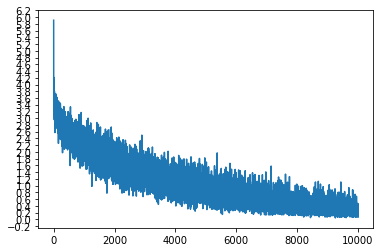

In [107]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, n_iters=100000, print_every=500, plot_every=10)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [108]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        # Encoder
        encoder_output, encoder_hidden = encoder1(input_tensor.unsqueeze(1))
        
        # Decoder
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden  )
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                """遇到终止符就停止
                """
                decoded_words.append('<EOS>')
                break
            else:
                """把decode的word加入数组中
                """
                decoded_words.append(output_lang.index2word[topi.item()])
                
            # 下一个的输入是上一个的输出
            decoder_input = topi.squeeze().detach()

        return decoded_words

In [109]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [110]:
evaluateRandomly(encoder1, decoder1, n=70)

> je suis egalement heureuse .
= i m happy too .
< i m happy too . <EOS>

> j attends de toi un travail serieux .
= i am expecting some serious work from you .
< i am expecting expecting serious serious serious . <EOS>

> tu es chanceuse .
= you re fortunate .
< you re fortunate . <EOS>

> je suis aussi choque que toi .
= i m as shocked as you are .
< i m as shocked as you are . <EOS>

> elles sont armees .
= they re armed .
< they re armed . <EOS>

> il est toujours chez lui le lundi .
= he is always at home on mondays .
< he s always at home on mondays . <EOS>

> tu es distraite .
= you re forgetful .
< you re forgetful . <EOS>

> nous sommes timides .
= we re shy .
< we re shy . <EOS>

> il est affaire en dehors de la ville .
= he s out of town on business .
< he s out of town on business . <EOS>

> je suis content de vous revoir .
= i m glad to see you back .
< i m glad to see you again . <EOS>

> vous etes surmenes .
= you re overworked .
< you re overworked . <EOS>

> je lance un